In [20]:
import numpy as np
from PIL import Image
from sklearn.metrics import mean_squared_error
from glob import glob
from natsort import natsorted
import os
from multiprocessing import Pool
from tqdm import tqdm

def compute_dice(gt_binary, pred_binary):
    intersection = np.sum(gt_binary * pred_binary)
    return 2. * intersection / (np.sum(gt_binary) + np.sum(pred_binary))

def compute_mse(gt, pred):
    return mean_squared_error(gt.flatten(), pred.flatten())

def process_model(model):
    mse_model_results = []
    dice_scores = []
    pred_model_probs = natsorted(glob(f'./results/{model}/cell_count_*/mask_test_image_prob.tif'))

    for gt_path, pred_prob_path in zip(gt_labels, pred_model_probs):
        gt_lbl = np.array(Image.open(gt_path))
        pred_prob_img = np.array(Image.open(pred_prob_path))

        gt_binary = (gt_lbl > 0).astype(int)
        pred_binary = (pred_prob_img > 0.5).astype(int)

        mse_model_results.append(compute_mse(gt_binary, pred_prob_img))
        dice_scores.append(compute_dice(gt_binary, pred_binary))

    return model, mse_model_results, dice_scores

gt_labels = natsorted(glob('./datasets/cell_count_*/test/masks/test_mask.tif'))
models = natsorted(os.listdir('./results'))

# Parallel processing with tqdm for progress tracking
with Pool() as pool:
    results = list(tqdm(pool.imap(process_model, models), total=len(models)))

mse_results = {}
dice_results = {}

for model, mse_model_results, model_dice_scores in results:
    mse_results[model] = mse_model_results
    dice_results[model] = model_dice_scores


100%|██████████| 13/13 [00:00<00:00, 34.75it/s]


Optimal Cell Count between: 28 and 38
FG Ratio between: 31.41021728515625% and 47.20611572265625%


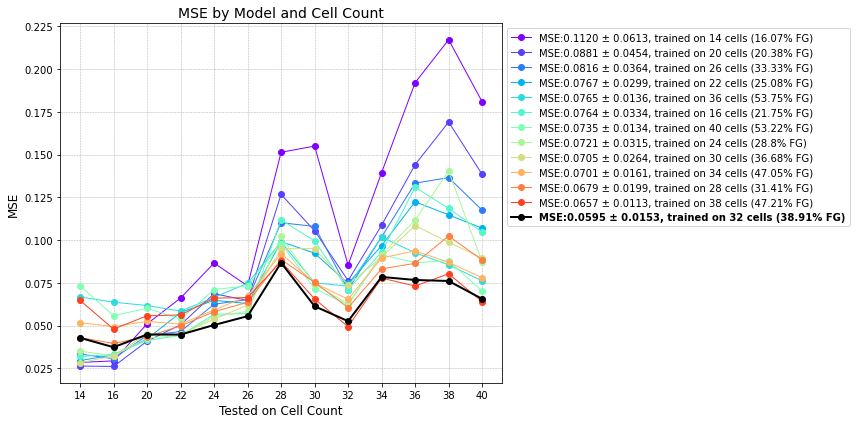

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from PIL import Image
from natsort import natsorted
from glob import glob

def calculate_foreground_ratio(labels):
    total_pixels = 0
    foreground_pixels = 0
    for label_path in labels:
        label = np.array(Image.open(label_path))
        foreground_pixels += np.sum(label > 0)
        total_pixels += label.size
    return foreground_pixels / total_pixels

# Extract all unique cell counts from models
unique_cell_counts = set()
for model in models:
    model_cell_count = model.split('_')[3]
    unique_cell_counts.add(model_cell_count)

# Calculate foreground ratios for these cell counts
foreground_ratios = {}
for cell_count in unique_cell_counts:
    train_labels = natsorted(glob(f'./datasets/cell_count_{cell_count}/train/masks/*.tif'))
    # Assuming calculate_foreground_ratio function is defined
    foreground_ratio = calculate_foreground_ratio(train_labels)
    foreground_ratios[cell_count] = foreground_ratio

# Extract cell counts
cell_counts = [path.split('/')[2].split('_')[2] for path in gt_labels]


# Sort models by their average MSE (from best to worst)
sorted_models = sorted(models, key=lambda m: np.mean(mse_results[m]))

# Take the top 5 models with the best MSE
top_5_models = sorted_models[:5]

# Extract cell counts and foreground ratios for these models
cell_counts_top_5 = [int(model.split('_')[3]) for model in top_5_models]
fg_ratios_top_5 = [foreground_ratios[str(count)]*100 for count in cell_counts_top_5]

# Calculate mean and standard deviation for cell counts and FG ratios
min_cell_count = np.min(cell_counts_top_5)
max_cell_count = np.max(cell_counts_top_5)

min_fg_ratio = np.min(fg_ratios_top_5)
max_fg_ratio = np.max(fg_ratios_top_5)

# Display the results
print(f"Optimal Cell Count between: {min_cell_count} and {max_cell_count}")
print(f"FG Ratio between: {min_fg_ratio}% and {max_fg_ratio}%")

# Sort models by their average MSE
sorted_models = sorted(models, key=lambda m: np.mean(mse_results[m]), reverse=True)

# Identify the model with the lowest MSE
lowest_mse_model = sorted_models[-1]
best_model, worst_model = sorted_models[-1], sorted_models[0]

best_model, worst_model = best_model.split('_')[3], worst_model.split('_')[3]

# Set plot size for better visibility
plt.figure(figsize=(12, 6))

# Generate unique colors for each model using a colormap
colors = cm.rainbow(np.linspace(0, 1, len(sorted_models)))

# Store handles for custom legend
handles = []

# Plotting MSE results for all models except the lowest MSE model
for i, model in enumerate(sorted_models):
    if model == lowest_mse_model:
        continue  # Skip the lowest MSE model for now
    
    mean_mse, std_mse = np.mean(mse_results[model]), np.std(mse_results[model])
    mean_mse, std_mse = format(round(mean_mse, 4), '.4f'), format(round(std_mse,4), '.4f')
    model_legend = model.split('_')[3]
    label_text = f'MSE:{mean_mse} ± {std_mse}, trained on {model_legend} cells ({round(foreground_ratios[model_legend]*100,2)}% FG)'
    
    line, = plt.plot(cell_counts, mse_results[model], marker='o', linestyle='-', color=colors[i], lw=1)
    handles.append((line, label_text))

# Plotting the lowest MSE model last so it's on top
mean_mse, std_mse = np.mean(mse_results[lowest_mse_model]), np.std(mse_results[lowest_mse_model])
mean_mse, std_mse = format(round(mean_mse, 4), '.4f'), format(round(std_mse, 4), '.4f')
model_legend = lowest_mse_model.split('_')[3]
label_text = f'MSE:{mean_mse} ± {std_mse}, trained on {model_legend} cells ({round(foreground_ratios[model_legend]*100,2)}% FG)'

line, = plt.plot(cell_counts, mse_results[lowest_mse_model], marker='o', linestyle='-', color='black', lw=2)
handles.append((line, label_text))

# Create custom legend
legend = plt.legend([h[0] for h in handles], [h[1] for h in handles], loc='upper left', bbox_to_anchor=(1, 1))
for i, text in enumerate(legend.get_texts()):
    if sorted_models[i] == lowest_mse_model:
        text.set_weight('bold')  # Set the specific text to bold

# Adding grid, labels, title
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Tested on Cell Count', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('MSE by Model and Cell Count', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('./pdfs/1 imgs per cell count (aug).pdf')
plt.show()


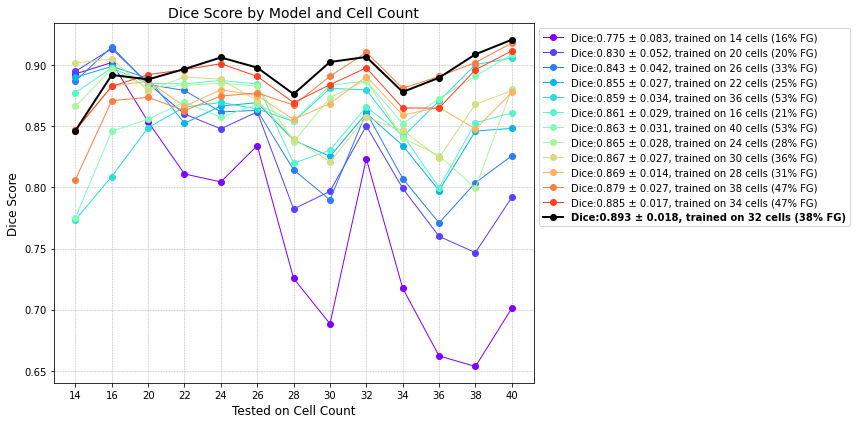

In [13]:
# Sort models by their average Dice score (from worst to best)
sorted_models = sorted(models, key=lambda m: np.mean(dice_results[m]))

# Identify the model with the best Dice score
best_dice_model = sorted_models[-1]

# Set plot size for better visibility
plt.figure(figsize=(12, 6))

# Generate unique colors for each model using a colormap
colors = cm.rainbow(np.linspace(0, 1, len(sorted_models)))

# Store handles for custom legend
handles = []

# Plotting Dice scores for sorted models
for i, model in enumerate(sorted_models):
    mean_dice, std_dice = np.mean(dice_results[model]), np.std(dice_results[model])
    mean_dice, std_dice = format(round(mean_dice, 3), '.4f'), format(round(std_dice, 3), '.4f')
    model_legend = model.split('_')[3]
    label_text = f'Dice:{mean_dice} ± {std_dice}, trained on {model_legend} cells ({int(foreground_ratios[model_legend]*100)}% FG)'
    
    line_color = 'black' if model == best_dice_model else colors[i]
    line_width = 2 if model == best_dice_model else 1
    
    line, = plt.plot(cell_counts, dice_results[model], marker='o', linestyle='-', 
             color=line_color, lw=line_width)

    # Add line to handles for custom legend
    handles.append((line, label_text))

# Create custom legend in the sorted order
legend = plt.legend([h[0] for h in handles], [h[1] for h in handles], loc='upper left', bbox_to_anchor=(1, 1))

# Bold the text for the best model in the legend
for i, text in enumerate(legend.get_texts()):
    if sorted_models[i] == best_dice_model:
        text.set_weight('bold')

# Adding grid, labels, title
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Tested on Cell Count', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.title('Dice Score by Model and Cell Count', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()

plt.show()

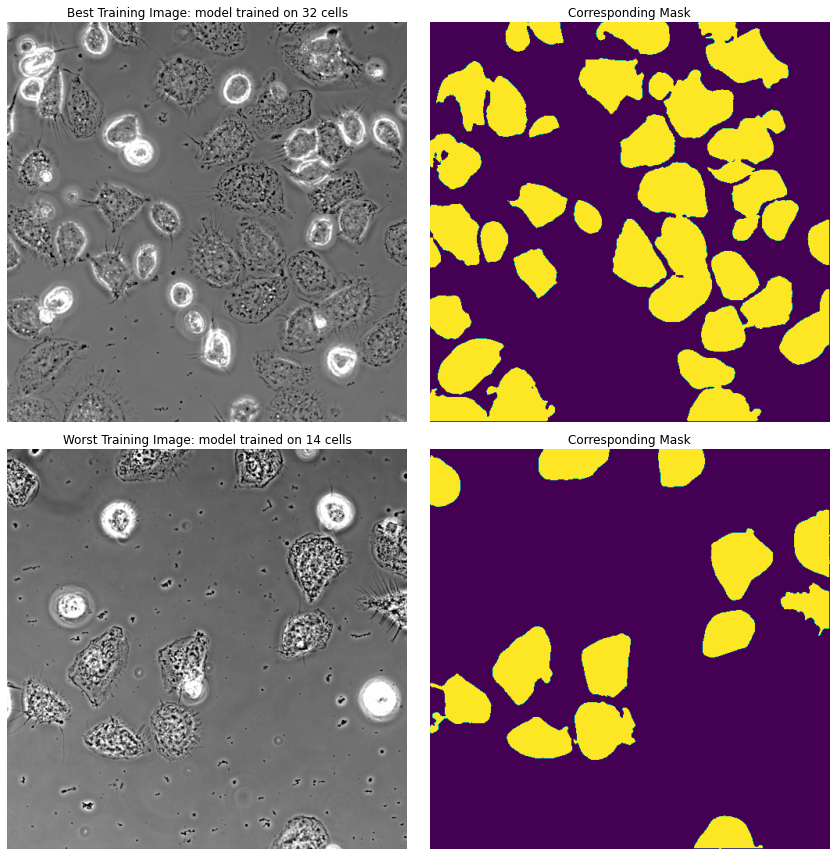

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted
from glob import glob
import numpy as np

# Assuming best_model and worst_model are defined
# Load the best and worst images and their corresponding masks
best_image_path = natsorted(glob(f'./datasets/cell_count_{best_model}/train/images/*.tif'))[0]
best_mask_path = natsorted(glob(f'./datasets/cell_count_{best_model}/train/masks/*.tif'))[0]
worst_image_path = natsorted(glob(f'./datasets/cell_count_{worst_model}/train/images/*.tif'))[0]
worst_mask_path = natsorted(glob(f'./datasets/cell_count_{worst_model}/train/masks/*.tif'))[0]

best_image = Image.open(best_image_path)
best_mask = Image.open(best_mask_path)
worst_image = Image.open(worst_image_path)
worst_mask = Image.open(worst_mask_path)

# Plotting both best and worst images and masks
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Best training image and mask
axes[0, 0].imshow(best_image, cmap='gray')
axes[0, 0].set_title(f'Best Training Image: model trained on {best_model} cells')
axes[0, 0].axis('off')

axes[0, 1].imshow(np.array(best_mask) > 0)
axes[0, 1].set_title('Corresponding Mask')
axes[0, 1].axis('off')

# Worst training image and mask
axes[1, 0].imshow(worst_image, cmap='gray')
axes[1, 0].set_title(f'Worst Training Image: model trained on {worst_model} cells')
axes[1, 0].axis('off')

axes[1, 1].imshow(np.array(worst_mask) > 0)
axes[1, 1].set_title('Corresponding Mask')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
